In [15]:
import numpy as np
import cv2
import openslide
import matplotlib.pyplot as plt 
from skimage.filters import threshold_otsu, median
from skimage.morphology import binary_dilation

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torchvision.datasets as dsets

from PIL import Image
import xml.etree.ElementTree as ET
from pathlib import Path
import time

import src.utils as utils
import os

In [16]:
def read_wsi(directory):
    paths = directory.glob("*.png")
    wsi_images = []
    for path in paths:
        wsi_image = cv2.imread(str(path))
        if wsi_image is not None:
            wsi_images.append(wsi_image)
    return wsi_images

In [17]:
def parse_xml_annotation(xml_path, mag_level):
    """
    Parse XML annotation to get bounding boxes of the tumor regions.

    :param xml_path: Path to the XML file.
    :param mag_level: Level at which I'm reading the WSI
    :return: List of bounding boxes in (x, y, width, height) format.
    """
    tree = ET.ElementTree(file=xml_path)
    root = tree.getroot()
    list_annotations = {}

    factor = 2**mag_level  
    i = 0
    for coords in root.iter('Coordinates'):
        vasc = []
        for coord in coords:
            vasc.append((int(float(coord.attrib.get("X"))/factor),int(float(coord.attrib.get("Y"))/factor)))
        list_annotations[i] = vasc
        i+=1
    return list_annotations

In [18]:
def extract_tissue_with_boxes_COMPLET(rgb_image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Perform Otsu thresholding on Hue and Saturation channels
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]
    otsu_thresh_hue = threshold_otsu(hue_channel)
    otsu_thresh_sat = threshold_otsu(sat_channel)
    binary_mask_hue = hue_channel <= otsu_thresh_hue
    binary_mask_sat = sat_channel <= otsu_thresh_sat

    # Create the Mask (Hue + Saturation channels)
    binary_mask = binary_mask_hue + binary_mask_sat

    # Mask improvements
    # Apply median filtering to remove spurious regions
    binary_mask = median(binary_mask, np.ones((7, 7)))
    # Dilate to add slight tissue buffer
    binary_mask = binary_dilation(binary_mask, np.ones((5, 5)))

    # Convert to uint8
    binary_mask = (binary_mask + 255).astype(np.uint8)

    # Find contours and create bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.contourArea(contour) > 750] # Filter small areas
    
    # Draw bounding boxes on the original image
    image_with_boxes = rgb_image.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
    
    return binary_mask, bounding_boxes, image_with_boxes

In [19]:
def extract_tissue_with_boxes(rgb_image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Perform Otsu thresholding on Hue and Saturation channels
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]
    otsu_thresh_hue = threshold_otsu(hue_channel)
    otsu_thresh_sat = threshold_otsu(sat_channel)
    binary_mask_hue = hue_channel <= otsu_thresh_hue
    binary_mask_sat = sat_channel <= otsu_thresh_sat

    # Create the Mask (Hue + Saturation channels)
    binary_mask = binary_mask_hue + binary_mask_sat

    # Mask improvements
    # Apply median filtering to remove spurious regions
    binary_mask = median(binary_mask, np.ones((7, 7)))
    # Dilate to add slight tissue buffer
    binary_mask = binary_dilation(binary_mask, np.ones((5, 5)))

    # Convert to uint8
    binary_mask = (binary_mask + 255).astype(np.uint8)

    # Find contours and create bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.contourArea(contour) > 750] # Filter small areas
    
    return binary_mask, bounding_boxes

In [7]:
def display_images(images,num_to_display=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_to_display):

        rgb_image = images[i]
        _, bounding_boxes, image_with_boxes= extract_tissue_with_boxes_COMPLET(rgb_image)

        plt.subplot(2, num_to_display, i + 1)
        plt.imshow(image_with_boxes)
        plt.title(f"Image {i+1} with Bounding Boxes")
        plt.axis('off')

        # Display tissue mask
        plt.subplot(2, num_to_display, num_to_display + i + 1)
        plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')  # Display grayscale version of original image
        for (x, y, w, h) in bounding_boxes:
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            plt.gca().add_patch(rect)
        plt.title(f"Tissue Zones {i+1}")
        plt.axis('off')
    plt.show()

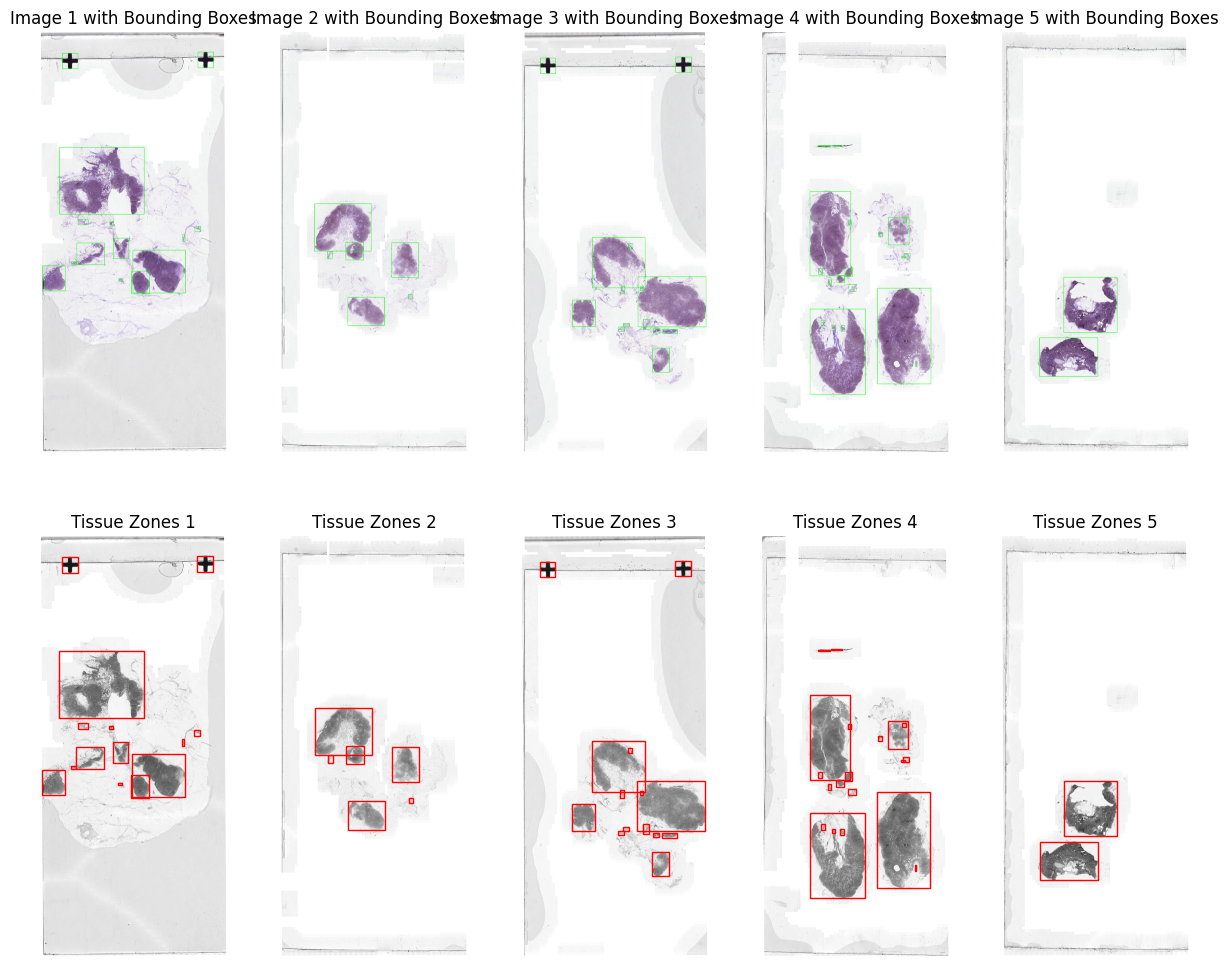

In [10]:
display_images(wsi_tumor_images,5)

In [20]:
def is_in_tumor_region(x, y, tumor_list):
        
        patch_size = utils.patch_size
        patch_bbox = [x, y, x + patch_size, y + patch_size]

        #generate bounding boxes for each annotation
        for i in range(len(tumor_list)):
            coords = np.array(tumor_list[i])
            x, y, w, h = cv2.boundingRect(coords)

            if (patch_bbox[0] >= x and patch_bbox[1] >= y and
            patch_bbox[2] <=y + w and patch_bbox[3] <= y + h):
                return True

        return False

In [21]:
# Example function to extract negative patches from normal WSI
patch_normal_index = 0
def extract_normal_patches_from_normal_wsi(wsi_path, wsi_image, bounding_boxes, patch_directory, patch_index):
    
    patch_size = utils.patch_size  # Example patch size, adjust as needed
    patch_per_box = utils.nb_patches_per_box
    mag_factor = pow(2,utils.mag_level)

    wsi_label, wsi_id = extract_info(wsi_path)
    
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        
        for i in range(patch_per_box):
            # Randomly choose patch coordinates within the bounding box
            patch_x = np.random.randint(x, x + w ) #MAYBE ADD "- patch_size"
            patch_y = np.random.randint(y, y + h )
            
            # Read region from WSI and convert to RGB array
            patch_image = wsi_image[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size,:]

            if (patch_image.shape[0] == 299 and patch_image.shape[1] == 299):
                # Save patch image
                patch_metadata = f"{wsi_label}_ {wsi_id}_{patch_x}_{patch_y}"
                patch_path = f"{patch_directory}/{patch_metadata}_{patch_index}.png"
                cv2.imwrite(patch_path, patch_image)
                patch_index += 1

                #perform data augmentation (rotation, flipping, color jitering)
                patch_index = patch_augmentation(patch_image, patch_directory, patch_metadata, patch_index)                    

    return patch_index

In [22]:
patch_normal_index = 0
def extract_normal_patches_from_tumor_wsi(wsi_path, wsi_image, anno_path, bounding_boxes, patch_directory, patch_index):
    
    patch_size = utils.patch_size  # Example patch size, adjust as needed
    patch_per_box = utils.nb_patches_per_box
    mag_factor = pow(2,utils.mag_level)
    
    #extract the annotations from xml file (already scaled for the magnification level used)
    annolist = parse_xml_annotation(anno_path, utils.mag_level)

    wsi_label, wsi_id = extract_info(wsi_path)

    for bbox in bounding_boxes:
        x, y, w, h = bbox
        
        patches_extracted = 0
        while patches_extracted < patch_per_box:
            # Randomly choose patch coordinates within the bounding box#
            patch_x = np.random.randint(x, x + w)
            patch_y = np.random.randint(y, y + h)
            
            # Check if the patch is in the tumor region
            if not is_in_tumor_region(patch_x, patch_y, annolist):

                # Read region from WSI and convert to array
                patch_image = wsi_image[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size, :]

                if (patch_image.shape[0] == 299 and patch_image.shape[1] == 299):
                    # Save patch image
                    patch_metadata = f"{wsi_label}_ {wsi_id}_{patch_x}_{patch_y}"
                    patch_path = f"{patch_directory}/{patch_metadata}_{patch_index}.png"
                    cv2.imwrite(patch_path, patch_image)
                    patch_index += 1
                
                    #perform data augmentation (rotation, flipping, color jitering)
                    patch_index = patch_augmentation(patch_image, patch_directory, patch_metadata, patch_index)
                patches_extracted += 1

    return patch_index


In [23]:
patch_tumor_index = 0
def extract_tumor_patches_from_tumor_wsi(wsi_path, wsi_image, anno_path, patch_directory, patch_index):
    #https://thedeeplearning-intern322.medium.com/extracting-patches-from-whole-slide-images-wsi-c3bb9b00d9b5

    patch_size = utils.patch_size  # Example patch size, adjust as needed
    patch_per_box = utils.nb_patches_per_box
    mag_factor = pow(2,utils.mag_level)

    #extract the annotations from xml file (already scaled for the magnification level used)
    annolist = parse_xml_annotation(anno_path, utils.mag_level)

    wsi_label, wsi_id = extract_info(wsi_path)
    
    #generate bounding boxes for each annotation
    for i in range(len(annolist)):                   
        coords = np.array(annolist[i])
        x, y, w, h = cv2.boundingRect(coords)

        #for each bounding box
        for j in range(patch_per_box):  

            # we sample random coordinates
            patch_x = np.random.randint(x, x + w) #MAYBE ADD "- patch_size"
            patch_y = np.random.randint(y, y + h)                      
            offsetx = np.random.randint(-50, 50)
            offsety = np.random.randint(-50, 50)
            spointx, spointy = patch_x + offsetx, patch_y + offsety 
            
            #we extract a patch and save it to the right directory
            patch_image = wsi_image[spointy:spointy + patch_size, spointx:spointx + patch_size,:]
            if (patch_image.shape[0] == 299 and patch_image.shape[1] == 299):

                patch_metadata = f"{wsi_label}_ {wsi_id}_{spointx}_{spointy}"
                patch_path = f"{patch_directory}/{patch_metadata}_{patch_index}.png"
                cv2.imwrite(patch_path, patch_image)
                patch_index += 1

                #perform data augmentation (rotation, flipping, color jitering)
                patch_index = patch_augmentation(patch_image, patch_directory, patch_metadata, patch_index)

    return patch_index

In [24]:
def patch_augmentation(patch_image, patch_directory, patch_metadata, patch_index):
    augmented_patches = []
    aug_patch = rotate_90(patch_image)
    augmented_patches.append(aug_patch)
    augmented_patches.append(random_flip(patch_image))
    augmented_patches.append(color_jitter(patch_image))

    for augmented_patch in augmented_patches:
        patch_path = f"{patch_directory}/{patch_metadata}_{patch_index}.png"
        cv2.imwrite(patch_path, augmented_patch)
        patch_index += 1

    return patch_index

In [25]:
def rotate_90(patch_image):
    #ADD 0 WHEN INTEGRATED TO PIPELINE
    angles = [1, 2, 3]  # Corresponds to 90, 180, 270 degree rotations counter-clockwise.
    angle = np.random.choice(angles)  # Choose a rotation at random.

    # Rotate the image using np.rot90
    rotated_patch_img = np.rot90(patch_image, k=angle)
 
    return rotated_patch_img

In [26]:
def random_flip(patch_image):

    flip_horizontal, flip_vertical = False, False
    
    while (flip_horizontal == False and flip_vertical == False):
        # Randomly decide whether to flip horizontally and/or vertically
        flip_horizontal = np.random.choice([True, False])
        flip_vertical = np.random.choice([True, False])

    # Perform flips if chosen
    if flip_horizontal:
        flipped_patch_img = np.flip(patch_image, axis=1)  # Horizontal flip
    if flip_vertical:
        flipped_patch_img = np.flip(patch_image, axis=0)  # Vertical flip

    return flipped_patch_img

In [28]:
def color_jitter(patch_array):
    
    # Define the color jittering transform
    color_jitter = transforms.ColorJitter(
        brightness=0.3,  # Adjust brightness
        contrast=0.3,    # Adjust contrast
        saturation=0.3,  # Adjust saturation
        hue=0.15          # Adjust hue
    )

    # Convert NumPy array to PIL Image
    patch_image = Image.fromarray(patch_array)

    # Apply the color jittering transform
    augmented_patch_image = color_jitter(patch_image)

    # Convert the augmented image back to a NumPy array
    augmented_patch_array = np.array(augmented_patch_image)

    return augmented_patch_array

In [29]:
def extract_info(path):
    # Extract the filename from the path
    filename = os.path.basename(path)
    
    # Split the filename into name and extension
    name, _ = os.path.splitext(filename)
    
    # Split the name into parts
    parts = name.split('_')
    
    # Extract the category and ID
    category = str(parts[0])
    id = str(parts[1])
    
    return category, id

In [58]:
patch_normal_index =0
patch_tumor_index = 0

In [30]:
# NORMAL PATCH FROM NORMAL SLIDES (TRAINING) 
for path in utils.train_normal_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    #extract the tissue
    _, bounding_boxes = extract_tissue_with_boxes(wsi_image)
    
    #extract normal patches 
    patch_normal_index = extract_normal_patches_from_normal_wsi(path, wsi_image, bounding_boxes, utils.train_normal_patch_path, patch_normal_index)
    
    print(f"FOR : {path} \nNumber of Bounding Box : {len(bounding_boxes)}\nNumber of patch extracted : {patch_normal_index}")

KeyboardInterrupt: 

In [70]:
# NORMAL PATCH FROM NORMAL SLIDE (VALIDATION)
for path in utils.val_normal_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    #extract the tissue
    _, bounding_boxes = extract_tissue_with_boxes(wsi_image)

    #extract normal patches 
    patch_normal_index = extract_normal_patches_from_normal_wsi(path, wsi_image, bounding_boxes, utils.val_normal_patch_path, patch_normal_index)
    print(f"FOR : {path} \nNumber of Bounding Box : {len(bounding_boxes)}\nNumber of patch extracted : {patch_normal_index}")
    

FOR : D:\CAMELYON16\data\validation\normal\normal_008.png 
Number of Bounding Box : 2
Number of patch extracted : 820


In [31]:
# TUMOR PATCH FROM TUMOR SLIDE (TRAINING)
for path in utils.train_tumor_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    _, wsi_id = extract_info(str(path))

    #read the annotations
    xml_path = utils.train_annotation_path / f"tumor_{int(wsi_id):03d}.xml"

    #extract tumor patches 
    patch_tumor_index = extract_tumor_patches_from_tumor_wsi(path,  wsi_image, xml_path, utils.train_tumor_patch_path, patch_tumor_index)
    print(f"FOR : {path} \nNumber of Bounding Box : {len(parse_xml_annotation(xml_path, utils.mag_level))}\nNumber of patch extracted : {patch_tumor_index}")
    

FOR : D:\CAMELYON16\data\training\tumor\tumor_001.png 
Number of Bounding Box : 2
Number of patch extracted : 40
FOR : D:\CAMELYON16\data\training\tumor\tumor_002.png 
Number of Bounding Box : 1
Number of patch extracted : 60


KeyboardInterrupt: 

In [77]:
# TUMOR PATCH FROM TUMOR SLIDE (VALIDATION)
for path in utils.val_tumor_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    _, wsi_id = extract_info(str(path))

    #read the annotations
    xml_path = utils.val_annotation_path / f"tumor_{int(wsi_id):03d}.xml"

    #extract tumor patches 
    patch_tumor_index = extract_tumor_patches_from_tumor_wsi(path, xml_path, wsi_image, utils.val_tumor_patch_path, patch_tumor_index)
    print(f"FOR : {path} \nNumber of Bounding Box (tumor) : {len(parse_xml_annotation(xml_path, utils.mag_level))}\nNumber of patch extracted : {patch_tumor_index}")
    

FOR : D:\CAMELYON16\data\validation\tumor\tumor_008.png 
Number of Bounding Box : 7
Number of patch extracted : 980


In [32]:
# NORMAL PATCH FROM TUMOR SLIDE (TRAINING)
for path in utils.train_tumor_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    _, wsi_id = extract_info(str(path))

    #extract the tissue
    _, bounding_boxes = extract_tissue_with_boxes(wsi_image)
    #read the annotations
    # xml_path = utils.train_annotation_path / f"tumor_{int(wsi_id):03d}.xml"
    xml_path = utils.train_annotation_path.glob(f"*{int(wsi_id)}.xml")

    #extract normal patches 
    patch_normal_index = extract_normal_patches_from_tumor_wsi(path, wsi_image, xml_path, bounding_boxes, utils.train_normal_patch_path, patch_normal_index)
    print(f"FOR : {path} \nNumber of Bounding Box : {len(bounding_boxes)}\nNumber of patch extracted : {patch_normal_index}")
    

KeyboardInterrupt: 

In [88]:
# NORMAL PATCH FROM TUMOR SLIDE (VALIDATION)
for path in utils.val_tumor_slide_path.glob("*.png"):
    #read the wsi
    wsi_image = cv2.imread(str(path))
    _, wsi_id = extract_info(str(path))

    #extract the tissue
    _, bounding_boxes = extract_tissue_with_boxes(wsi_image)
    #read the annotations
    xml_path = utils.val_annotation_path / f"tumor_{int(wsi_id):03d}.xml"

    #extract normal patches 
    patch_normal_index = extract_normal_patches_from_tumor_wsi(path, wsi_image, xml_path, bounding_boxes, utils.val_normal_patch_path, patch_normal_index)
    print(f"FOR : {path} \nNumber of Bounding Box : {len(bounding_boxes)}\nNumber of patch extracted : {patch_normal_index}")
    

FOR : D:\CAMELYON16\data\validation\tumor\tumor_008.png 
Number of Bounding Box : 12
Number of patch extracted : 2844


In [15]:
patch_normal_index

0

In [90]:
patch_tumor_index

980

### DEEP LEARNING MODEL

In [3]:
def count_patches(directory):

    return len(list(directory.glob("*.png")))

def print_patch_counts(train_dir, val_dir, category):

    train_count = count_patches(train_dir)
    val_count = count_patches(val_dir)

    print(f"{category} patches count:")
    print(f"Train: {train_count}")
    print(f"Validation: {val_count}")

# Count and print the number of patches in each directory
print_patch_counts(utils.train_normal_patch_path, utils.val_normal_patch_path, "Normal")
print_patch_counts(utils.train_tumor_patch_path, utils.val_tumor_patch_path, "Tumor")


Normal patches count:
Train: 2576
Validation: 268
Tumor patches count:
Train: 840
Validation: 140


### Transfer learnin using Inception V3
##### https://github.com/Harry24k/Pytorch-Basic/blob/master/Week5/20.%20Transfer%20Learning%20with%20Inception%20v3.ipynb

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder(utils.train_patch_dir, train_transform)
val_data = dsets.ImageFolder(utils.val_patch_dir, val_transform)

In [5]:
batch_size = 5

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(val_data, 
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [6]:
model = models.inception_v3(weights=True)

d:\Userssgnetanaconda3\envs\camelyon_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

In [8]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [9]:
# Use CPU instead of CUDA
device = torch.device("cpu")
model = model.to(device)

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [11]:
num_epochs = 15
# Initialize lists to store the training and validation losses
train_losses = []
val_losses = []

In [13]:
for epoch in range(num_epochs):
    model.train()
    epoch_start_time = time.time()  # Start time of the epoch
    
    total_batch = len(train_data) // batch_size
    train_loss = 0.0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        train_loss += cost.item()

        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_cost = loss(val_outputs, val_labels)
            
            val_loss += val_cost.item()
    
    val_losses.append(val_loss / len(val_loader))



    epoch_end_time = time.time()  # End time of the epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print('Epoch [%d/%d] completed in %.2f seconds' % (epoch + 1, num_epochs, epoch_duration))
    print('Training Loss: %.4f, Validation Loss: %.4f' % (train_losses[-1], val_losses[-1]))

# Save model
torch.save(model.state_dict(), "D:/CAMELYON16/camelyon_dissertation/models/inceptionV3_test")

Epoch [1/15], lter [5/683] Loss: 0.2112


KeyboardInterrupt: 

In [1]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

NameError: name 'plt' is not defined

In [83]:
# Save model
torch.save(model.state_dict(), "D:/CAMELYON16/camelyon_dissertation/models/inceptionV3_test")

In [32]:
# Initialize the model architecture
model = models.inception_v3(weights=None)  # Initialize without pre-trained weights
model.aux_logits = False  # Disable auxiliary logits

# Recreate the same custom fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

# Load the saved state dictionary
model.load_state_dict(torch.load("D:/CAMELYON16/camelyon_dissertation/models/inceptionV3_test"))

# Set the model to evaluation mode
model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [35]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.to(device)
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 57.674419 %


Accuracy of test images: 57.67 %


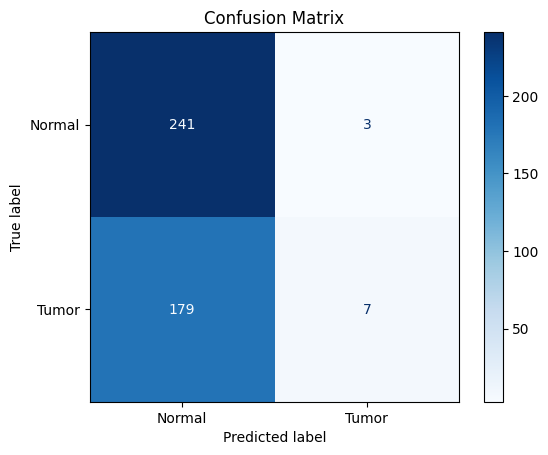

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Evaluate the model
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * float(correct) / total
print(f'Accuracy of test images: {accuracy:.2f} %')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Define the classes (Update according to your dataset)
classes = ["Normal", "Tumor"]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()